## **Getting started**

This code implements the **Variational Neural Algorithm** with **Dilated RNNs** to find the ground state of the **Sherrington Kirkpatrick (SK)** model, whose Hamiltonian is given by:
$$ H = -\frac{1}{2\sqrt{N}}\sum_{i \neq j} J_{ij} \sigma_i \sigma_j, $$
where $\sigma_i = \pm 1$ and $J_{ij}$ are random couplings are sampled from a gaussian distribution with mean 0 and variance 1.

This code is based on [RNN wave function's code](https://github.com/mhibatallah/RNNWavefunctions). Edited by Mohamed Hibat-Allah and Estelle Inack.

In [ ]:
# This enforces the use of Tensorflow 1.x instead of the default Tensorflow 2.x
%tensorflow_version 1.x
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) #stop displaying tensorflow warnings
import numpy as np
import os
import time
import random
import matplotlib.pyplot as plt
from math import ceil

#For plotting purposes
from matplotlib import rcParams

rcParams['axes.labelsize']  = 20
rcParams['font.serif']      = ['Computer Modern']
rcParams['font.size']       = 10
rcParams['legend.fontsize'] = 20
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20

TensorFlow 1.x selected.


In [ ]:
#Seeding for reproducibility purposes
seed = 111 #Seeding for reproducibility purposes
tf.compat.v1.reset_default_graph()
random.seed(seed)  # `python` built-in pseudo-random generator
np.random.seed(seed)  # numpy pseudo-random generator
tf.compat.v1.set_random_seed(seed)  # tensorflow pseudo-random generator

## **Helper Functions**

The function **Fullyconnected_diagonal_matrixelements** computes the diagonal matrix elements given a set of configurations **samples** and the couplings **Jz** for a fully-connected spin model.

In [ ]:
def Fullyconnected_diagonal_matrixelements(Jz, samples):
    """ To get the diagonal local energies of a fully-connected spin model given a set of set of samples in parallel!
    Returns: The local energies that correspond to the "samples"
    Inputs:
    - samples: (numsamples, N)
    - Jz: (N,N) np array of J_ij couplings
    """
    
    numsamples = len(samples)
    energies = np.zeros((numsamples), dtype = np.float64)

    for i in range(N-1):
      # for j in range(i+1,N):
      values = np.expand_dims(samples[:,i], axis = -1)+samples[:,i+1:]
      valuesT = np.copy(values)
      valuesT[values==2] = +1 #If both spins are up
      valuesT[values==0] = +1 #If both spins are down
      valuesT[values==1] = -1 #If they are opposite

      energies += np.sum(valuesT*(-Jz[i,i+1:]), axis = 1)

    return energies

**Fullyconnected_localenergies** is used to compute the expectation value of the Hamiltonian over the variational state.

A fully-connected model (such as SK model) in the quantum setting, is given by
$$ \hat{H} = - \frac{1}{2} \sum_{i \neq j } J_{ij} \hat{\sigma}^{z}_i \hat{\sigma}^{z}_j - B_x \sum_{i=1}^{N} \hat{\sigma}^{x}_i,$$
where $\hat{\sigma}^{z}_i$ and $\hat{\sigma}^{x}_i$ are respectivelly the Pauli z and x matrices at site $i$. 
The formula for average energy over the variational state is 
$\langle \hat{H} \rangle = \langle\Psi_{\lambda}| \hat{H} |\Psi_{\lambda} \rangle = \sum_{\sigma} {|\Psi_{\lambda}(\sigma)|}^{2} E_{loc}(\sigma) $, where $E_{loc}(\sigma) = \frac{\langle \sigma | \hat{H}|\Psi_{\lambda}\rangle}{\langle \sigma |\Psi_{\lambda}\rangle}$.

In [ ]:
def Fullyconnected_localenergies(Jz, Bx, samples, queue_samples, log_probs_tensor, samples_placeholder, log_probs, sess):
    """ To get the local energies of a fully-connected spin model given a set of set of samples in parallel!
    Returns: The local energies that correspond to the "samples"
    Inputs:
    - samples: (numsamples, N)
    - Jz: (N,N) np array of J_ij couplings
    - Bx: float
    - queue_samples: ((N+1)*numsamples, N) an allocated np array to store all the sample applying the Hamiltonian H on samples
    - log_probs_tensor: A TF tensor with size (None)
    - samples_placeholder: A TF placeholder to feed in a set of configurations
    - log_probs: ((N+1)*numsamples): an allocated np array to store the log_probs non diagonal elements
    - sess: The current TF session
    """
    
    numsamples = len(samples)
    local_energies = np.zeros((numsamples), dtype = np.float64)

    for i in range(N-1):
      # for j in range(i+1,N):
      values = np.expand_dims(samples[:,i], axis = -1)+samples[:,i+1:]
      valuesT = np.copy(values)
      valuesT[values==2] = +1 #If both spins are up
      valuesT[values==0] = +1 #If both spins are down
      valuesT[values==1] = -1 #If they are opposite

      local_energies += np.sum(valuesT*(-Jz[i,i+1:]), axis = 1)
    # local_energies += -N*np.mean((2*samples-1), axis = 1)**3

    queue_samples[0] = samples #storing the diagonal samples

    if Bx != 0:
        count = 0
        for i in range(N-1):  #Non-diagonal elements
            valuesT = np.copy(samples)
            valuesT[:,i][samples[:,i]==1] = 0 #Flip spin i
            valuesT[:,i][samples[:,i]==0] = 1 #Flip spin i


            count += 1
            queue_samples[count] = valuesT

        len_sigmas = (N+1)*numsamples
        steps = len_sigmas//50000+1 #I want a maximum of 50000 in batch size just to be safe I don't allocate too much memory

        queue_samples_reshaped = np.reshape(queue_samples, [(N+1)*numsamples, N])
        for i in range(steps):
          if i < steps-1:
              cut = slice((i*len_sigmas)//steps,((i+1)*len_sigmas)//steps)
          else:
              cut = slice((i*len_sigmas)//steps,len_sigmas)
          log_probs[cut] = sess.run(log_probs_tensor, feed_dict={samples_placeholder:queue_samples_reshaped[cut]})


        log_probs_reshaped = np.reshape(log_probs, [N+1,numsamples])
        for j in range(numsamples):
            local_energies[j] += -Bx*np.sum(0.5*(np.exp(log_probs_reshaped[1:,j]-log_probs_reshaped[0,j])))

    return local_energies

## **Dilated RNN Wavefunction Class**

Here, we define the Dilated RNNwavefunction class, which contains the **sample** method that allows to sample configurations autoregressively from the RNN and the **log_probability** method which allows to estimate the log-probability of a set of configurations.

Note that the log probabilities $\log P_{\lambda}(\sigma)$ are used here because we assume that the ground state wavefunction has non-negative amplitudes. Thus, we can write $\Psi_{\lambda}(\sigma) = \sqrt{P_{\lambda}(\sigma)}$, where $\lambda$ stands for the variational parameters.

We also note that the dilated connections between RNN cells allow to take care of the long-distance dependencies between spins more efficiently, as explained in https://arxiv.org/abs/2101.10154.

In [ ]:
class DilatedRNNWavefunction(object):
    def __init__(self,systemsize,cell=tf.nn.rnn_cell.BasicRNNCell,activation=tf.nn.relu,units=[2],scope='DilatedRNNwavefunction', seed = 111):
        """
            systemsize:  int
                         number of sites
            cell:        a tensorflow RNN cell
            units:       list of int
                         number of units per RNN layer
            scope:       str
                         the name of the name-space scope
            activation:  activation of the RNN cell
            seed:        pseudo-random number generator
        """

        self.graph=tf.Graph()
        self.scope=scope #Label of the RNN wavefunction
        self.N=systemsize #Number of sites of the 1D chain
        self.numlayers = len(units)
        random.seed(seed)  # `python` built-in pseudo-random generator
        np.random.seed(seed)  # numpy pseudo-random generator

        #Defining the neural network
        with self.graph.as_default():
            with tf.variable_scope(self.scope,reuse=tf.AUTO_REUSE):
                tf.set_random_seed(seed)  # tensorflow pseudo-random generator
                
                #Define the RNN cell where units[n] corresponds to the number of memory units in each layer n
                self.rnn=[[cell(num_units = units[i], activation = activation,name="rnn_"+str(n)+str(i),dtype=tf.float64) for n in range(self.N)] for i in range(self.numlayers)]
                self.dense = [tf.layers.Dense(2,activation=tf.nn.softmax,name='wf_dense'+str(n)) for n in range(self.N)] #Define the Fully-Connected layer followed by a Softmax

    def sample(self,numsamples,inputdim):
        """
            generate samples from a probability distribution parametrized by a recurrent network
            ------------------------------------------------------------------------
            Parameters:
            numsamples:      int
                             number of samples to be produced
            inputdim:        int
                             hilbert space dimension
            ------------------------------------------------------------------------
            Returns:
            samples:         tf.Tensor of shape (numsamples,systemsize)
                             the samples in integer encoding
        """
        with self.graph.as_default(): #Call the default graph, used if willing to create multiple graphs.
            samples = []
            probs = []
            with tf.variable_scope(self.scope,reuse=tf.AUTO_REUSE):

                inputs=tf.zeros((numsamples,inputdim), dtype = tf.float64) #Feed the table b in tf.
                #Initial input to feed to the rnn

                self.inputdim=inputs.shape[1]
                self.outputdim=self.inputdim
                self.numsamples=inputs.shape[0]

                rnn_states = []

                for i in range(self.numlayers):
                    for n in range(self.N):
                        # rnn_states.append(1.0-self.rnn[i].zero_state(self.numsamples,dtype=tf.float64)) #Initialize the RNN hidden state
                        rnn_states.append(self.rnn[i][n].zero_state(self.numsamples,dtype=tf.float64)) #Initialize the RNN hidden state
                #zero state returns a zero filled tensor withs shape = (self.numsamples, num_units)

                for n in range(self.N):

                    rnn_output = inputs

                    for i in range(self.numlayers):
                        if (n-2**i)>=0:
                            rnn_output, rnn_states[i + n*self.numlayers] = self.rnn[i][n](rnn_output, rnn_states[i+((n-2**i)*self.numlayers)]) #Compute the next hidden states
                        else:
                            rnn_output, rnn_states[i + n*self.numlayers] = self.rnn[i][n](rnn_output, rnn_states[i])

                    output=self.dense[n](rnn_output) 
                    probs.append(output)
                    sample_temp=tf.reshape(tf.multinomial(tf.log(output),num_samples=1),[-1,]) #Sample from the probability
                    samples.append(sample_temp)
                    inputs=tf.one_hot(sample_temp,depth=self.outputdim,dtype = tf.float64)

        probs=tf.transpose(tf.stack(values=probs,axis=2),perm=[0,2,1])
        self.samples=tf.stack(values=samples,axis=1) # (self.N, num_samples) to (num_samples, self.N): Generate self.numsamples vectors of size self.N spin containing 0 or 1
        one_hot_samples=tf.one_hot(self.samples,depth=self.inputdim, dtype = tf.float64)
        self.log_probs=tf.reduce_sum(tf.log(tf.reduce_sum(tf.multiply(probs,one_hot_samples),axis=2)),axis=1)

        return self.samples,self.log_probs

    def log_probability(self,samples,inputdim):
        """
            calculate the log-probabilities of ```samples``
            ------------------------------------------------------------------------
            Parameters:
            samples:         tf.Tensor
                             a tf.placeholder of shape (number of samples,systemsize)
                             containing the input samples in integer encoding
            inputdim:        int
                             dimension of the input space
            ------------------------------------------------------------------------
            Returns:
            log-probs        tf.Tensor of shape (number of samples,)
                             the log-probability of each sample
            """
        with self.graph.as_default():

            self.inputdim=inputdim
            self.outputdim=self.inputdim

            self.numsamples=tf.shape(samples)[0]

            inputs=tf.zeros((self.numsamples, self.inputdim), dtype=tf.float64)

            with tf.variable_scope(self.scope,reuse=tf.AUTO_REUSE):
                probs=[]

                rnn_states = []

                for i in range(self.numlayers):
                    for n in range(self.N):
                        rnn_states.append(self.rnn[i][n].zero_state(self.numsamples,dtype=tf.float64)) #Initialize the RNN hidden state
                #zero state returns a zero filled tensor withs shape = (self.numsamples, num_units)

                for n in range(self.N):

                    rnn_output = inputs

                    for i in range(self.numlayers):
                        if (n-2**i)>=0:
                            rnn_output, rnn_states[i + n*self.numlayers] = self.rnn[i][n](rnn_output, rnn_states[i+((n-2**i)*self.numlayers)]) #Compute the next hidden states
                        else:
                            rnn_output, rnn_states[i + n*self.numlayers] = self.rnn[i][n](rnn_output, rnn_states[i])

                    output=self.dense[n](rnn_output)
                    probs.append(output)
                    inputs=tf.reshape(tf.one_hot(tf.reshape(tf.slice(samples,begin=[np.int32(0),np.int32(n)],size=[np.int32(-1),np.int32(1)]),shape=[self.numsamples]),depth=self.outputdim,dtype = tf.float64),shape=[self.numsamples,self.inputdim])

            probs=tf.cast(tf.transpose(tf.stack(values=probs,axis=2),perm=[0,2,1]),tf.float64)
            one_hot_samples=tf.one_hot(samples,depth=self.inputdim, dtype = tf.float64)

            self.log_probs=tf.reduce_sum(tf.log(tf.reduce_sum(tf.multiply(probs,one_hot_samples),axis=2)),axis=1)

            return self.log_probs


## **Hyperparameters**

Here we define the hyperparameters used in our variational annealing protocol.

**Note:**

If $B_{x0} = 0$, then this code will run Variational Classical Annealing (VCA).

If $T_0 = 0$, then this code will run Variational Quantum Annealing (VQA).

If both are zero, then this algorithm will correspond to classical quantum optimization (CQO).

For more details, please check Ref. https://arxiv.org/abs/2101.10154.

In [ ]:
N = 20 #total number of spins
num_units = 20 #number of memory units for each RNN cell
numlayers = ceil(np.log2(N)) #number of layers
numsamples = 50 #number of samples used for training
lr = 1e-3 #learning rate
T0 = 2 #initial temperature
Bx0 = 2 #initial magnetic field 
num_warmup_steps = 1000 #number of warmup steps
num_annealing_steps = 500 #number of annealing steps
num_equilibrium_steps = 5 #number of training steps after each annnealing step
activation_function = tf.nn.elu #activation function used for the Dilated RNN cell

Jz = np.random.normal(0,1/np.sqrt(N),size = (N,N)) #SK model couplings

#Defining the other parameters
units=[num_units]*numlayers #list containing the number of hidden units for each layer of the RNN

print('\n')
print("Number of spins =", N)
print("Initial_temperature =", T0)
print('Seed = ', seed)

num_steps = num_annealing_steps*num_equilibrium_steps + num_warmup_steps

print("\nNumber of annealing steps = {0}".format(num_annealing_steps))
print("Number of training steps = {0}".format(num_steps))
print("Number of layers = {0}\n".format(numlayers))



Number of spins = 20
Initial_temperature = 2
Seed =  111

Number of annealing steps = 500
Number of training steps = 3500
Number of layers = 5



## **Initializing and Building the Graph**

Here we define the Dilated RNNWavefunction class, along with the optimizer, gradients and placeholders needed for the optimization of the RNN.

In [ ]:
# Intitializing the RNN-----------
DRNNWF = DilatedRNNWavefunction(N,units=units,cell=tf.nn.rnn_cell.BasicRNNCell, activation = activation_function, seed = seed) #contains the graph with the RNNs

In [ ]:
#Building the graph -------------------
with tf.compat.v1.variable_scope(DRNNWF.scope,reuse=tf.compat.v1.AUTO_REUSE):
    with DRNNWF.graph.as_default():

        global_step = tf.Variable(0, trainable=False)
        learningrate_placeholder = tf.compat.v1.placeholder(dtype=tf.float64,shape=[])
        learningrate = tf.compat.v1.train.exponential_decay(learningrate_placeholder, global_step, 100, 1.0, staircase=True)

        #Defining the optimizer
        optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=learningrate)

        #Defining Tensorflow placeholders
        Eloc=tf.compat.v1.placeholder(dtype=tf.float64,shape=[numsamples])
        sampleplaceholder_forgrad=tf.compat.v1.placeholder(dtype=tf.int32,shape=[numsamples,N])
        log_probs_forgrad = DRNNWF.log_probability(sampleplaceholder_forgrad,inputdim=2)
        samples_placeholder=tf.compat.v1.placeholder(dtype=tf.int32,shape=(None,N))
        log_probs_tensor=DRNNWF.log_probability(samples_placeholder,inputdim=2)
        samplesandprobs = DRNNWF.sample(numsamples=numsamples,inputdim=2)

        T_placeholder = tf.compat.v1.placeholder(dtype=tf.float64,shape=())

        #Here we define a fake cost function that would allows to get the gradients of free energy using the tf.stop_gradient trick
        Floc = Eloc + T_placeholder*log_probs_forgrad
        cost = tf.reduce_mean(tf.multiply(log_probs_forgrad,tf.stop_gradient(Floc))) - tf.reduce_mean(log_probs_forgrad)*tf.reduce_mean(tf.stop_gradient(Floc))

        gradients, variables = zip(*optimizer.compute_gradients(cost))
        #Calculate Gradients---------------

        #Define the optimization step
        optstep=optimizer.apply_gradients(zip(gradients,variables), global_step = global_step)

        #Tensorflow saver to checkpoint
        saver=tf.compat.v1.train.Saver()

        #For initialization
        init=tf.compat.v1.global_variables_initializer()
        initialize_parameters = tf.initialize_all_variables()
#----------------------------------------------------------------


Here we initialize the tensorflow session:

In [ ]:
#Starting Session------------
#GPU management
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

sess=tf.compat.v1.Session(graph=DRNNWF.graph, config=config)
sess.run(init)

#Loading previous trainings----------
    ### To be implemented
#------------------------------------

## **Running variational annealing**

In this part of the code, we implement our variational annealing protocol.

Here, we follow a linear schedule for temperature:

$$ T(t) = T_0 (1-t/N_{\rm annealing}) $$
and for transverse magnetic field:
$$ B_x(t) = B_{x0} (1-t/N_{\rm annealing}) $$

In [ ]:
with tf.compat.v1.variable_scope(DRNNWF.scope,reuse=tf.compat.v1.AUTO_REUSE):
    with DRNNWF.graph.as_default():

      #To store data
      meanEnergy=[]
      varEnergy=[]
      varFreeEnergy = []
      meanFreeEnergy = []
      samples = np.ones((numsamples, N), dtype=np.int32)
      queue_samples = np.zeros((N+1, numsamples, N), dtype = np.int32) #Array to store all the diagonal and non diagonal matrix elements (We create it here for memory efficiency as we do not want to allocate it at each training step)
      log_probs = np.zeros((N+1)*numsamples, dtype=np.float64) #Array to store the log_probs of all the diagonal and non diagonal matrix elements (We create it here for memory efficiency as we do not want to allocate it at each training step)

      T = T0 #initializing temperature
      Bx = Bx0 #initializing magnetic field

      sess.run(initialize_parameters) #Reinitialize the parameters

      start = time.time()

      for it in range(len(meanEnergy),num_steps+1):

            #Annealing
            if it>=num_warmup_steps and  it <= num_annealing_steps*num_equilibrium_steps + num_warmup_steps and it % num_equilibrium_steps == 0:
              annealing_step = (it-num_warmup_steps)/num_equilibrium_steps
              T = T0*(1-annealing_step/num_annealing_steps)
              Bx = Bx0*(1-annealing_step/num_annealing_steps)

            #Showing current status after that the annealing starts
            if it%num_equilibrium_steps==0:
              if it <= num_annealing_steps*num_equilibrium_steps + num_warmup_steps and it>=num_warmup_steps:
                  annealing_step = (it-num_warmup_steps)/num_equilibrium_steps
                  print("\nAnnealing step: {0}/{1}".format(annealing_step,num_annealing_steps))

            samples, log_probabilities = sess.run(samplesandprobs)

            # Estimating the local energies
            local_energies = Fullyconnected_localenergies(Jz, Bx, samples, queue_samples, log_probs_tensor, samples_placeholder, log_probs, sess)

            meanE = np.mean(local_energies)
            varE = np.var(local_energies)

            #adding elements to be saved
            meanEnergy.append(meanE)
            varEnergy.append(varE)

            meanF = np.mean(local_energies+T*log_probabilities)
            varF = np.var(local_energies+T*log_probabilities)
            
            meanFreeEnergy.append(meanF)
            varFreeEnergy.append(varF)

            if it%num_equilibrium_steps==0:
                print('mean(E): {0}, mean(F): {1}, var(E): {2}, var(F): {3}, #samples {4}, #Training step {5}'.format(meanE,meanF,varE,varF,numsamples, it))
                print("Temperature: ", T)
                print("Magnetic field: ", Bx)


            #Here we produce samples at the end of annealing
            if it == num_annealing_steps*num_equilibrium_steps + num_warmup_steps:

                Nsteps = 20
                numsamples_estimation = 10**5 #Num samples to be obtained at the end 
                numsamples_perstep = numsamples_estimation//Nsteps #The number of steps taken to get "numsamples_estimation" samples (to avoid memory allocation issues) 

                samplesandprobs_final = DRNNWF.sample(numsamples=numsamples_perstep,inputdim=2)
                energies = np.zeros((numsamples_estimation))
                solutions = np.zeros((numsamples_estimation, N))
                print("\nSaving energy and variance before the end of annealing")

                for i in range(Nsteps): 
                    # print("\nsampling started")
                    samples_final, _ = sess.run(samplesandprobs_final)
                    # print("\nsampling finished") 
                    energies[i*numsamples_perstep:(i+1)*numsamples_perstep] = Fullyconnected_diagonal_matrixelements(Jz,samples_final) 
                    solutions[i*numsamples_perstep:(i+1)*numsamples_perstep] = samples_final
                    print("Sampling step:" , i+1, "/", Nsteps)
                print("meanE = ", np.mean(energies))
                print("varE = ", np.var(energies))
                print("minE = ",np.min(energies))

            #Run gradient descent step
            sess.run(optstep,feed_dict={Eloc:local_energies, sampleplaceholder_forgrad: samples, learningrate_placeholder: lr, T_placeholder:T})

            if it%5 == 0:
                print("Elapsed time is =", time.time()-start, " seconds")
                print('\n\n')

#----------------------------

Streaming output truncated to the last 5000 lines.
Elapsed time is = 22.754387617111206  seconds



mean(E): -21.24913291023508, mean(F): -48.687584577401104, var(E): 1.1577930238527019, var(F): 0.28917926006618344, #samples 50, #Training step 670
Temperature:  2
Magnetic field:  2
Elapsed time is = 22.893412113189697  seconds



mean(E): -21.421245822276607, mean(F): -48.90414430833423, var(E): 0.7217095890122472, var(F): 0.20411864936647842, #samples 50, #Training step 675
Temperature:  2
Magnetic field:  2
Elapsed time is = 23.0278000831604  seconds



mean(E): -21.431481643961543, mean(F): -48.827324255871716, var(E): 1.193163011371349, var(F): 0.2622838387383081, #samples 50, #Training step 680
Temperature:  2
Magnetic field:  2
Elapsed time is = 23.155739307403564  seconds



mean(E): -21.180771897726146, mean(F): -48.855280638299355, var(E): 1.0246292041214808, var(F): 0.19241691033848188, #samples 50, #Training step 685
Temperature:  2
Magnetic field:  2
Elapsed time is = 23.28

## **Plotting Histogram**

Here we plot the residual energy  per site $\epsilon_{\rm res} = (E_{\rm RNN} - E_G)/N$ at the end of annealing in a histogram form, where $E_G$ is the exact ground state energy obtained from the spin-glass server https://software.cs.uni-koeln.de/spinglass/.

In the plot below, we see that the RNN manages to obtain the exact ground state energy with a high probability within a threshold of 1e-10.

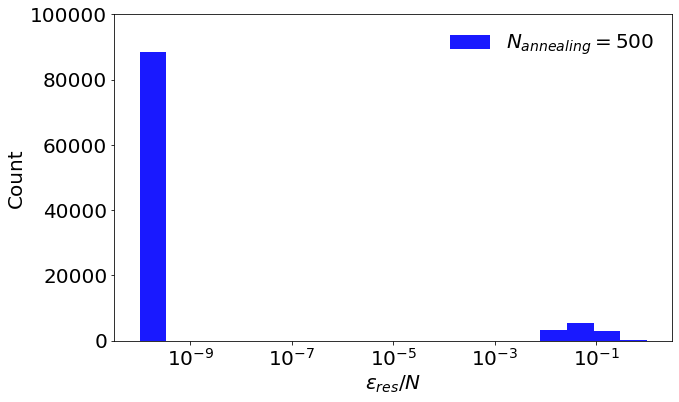

In [ ]:
MIN, MAX = 1e-10, 1.0
tol = 1e-10
gsenergy = -0.54069855*N #Exact ground state energy obtained from spin glass server "https://software.cs.uni-koeln.de/spinglass/" for N = 100 and seed = 111
eres = ((energies - gsenergy)/N)
eres[eres<=0.0] = tol # eres<=0.0 might happen because of lack of numerical accuracy of the value of gsenergy given by spin-glass server

plt.figure(figsize=(10,6))
plt.hist(eres, alpha=0.9, color='b', bins = 10 ** np.linspace(np.log10(MIN), np.log10(MAX), 20), label='$N_{annealing}='+str(num_annealing_steps)+'$')

plt.gca().set_xscale("log")
plt.ylim(0, np.size(energies) )
plt.legend(loc='best', frameon=False)
plt.xlabel(r'$\epsilon_{res}/N$')
plt.ylabel('Count')
plt.show()